## How to interpret DATE results

* Written by Yu-Che Tsai, Department of Statistics, National Cheng Kung University
* Revised by Sundong Kim, Institute for Basic Science

## Short Summary
DATE first takes a set of leaf-node from the pre-trained XGBoost classifier as input. It then applies the attention mechanism by incorporating the ID embedding and HS6 code embedding. The attention mechanism was used to dynamically assign weights to each leaf-node(i.e., cross-features), leaf-nodes with a higher weights means it contribute more to our prediction results. After we trained DATE on a specific dataset, we could feed unseen data and observe the attention distribution to determine which cross-feature contributes more to our prediction.

## Requirements
* A trained XGBoost classifier, which should be saved after training (should be a .txt file).
* A trained DATE model, saved with .pkl file. It should be saved as `../saved_models/DATE_0.xxxx.pkl`
* leaf_index.pickle to be used for projecting leaf-index to tree structure.
* Dataset to analysis could be either training data or test data.

## Dataset
* Synthetic dataset
* Since we have already trained DATE with a set of training data, we only analyze the testing set in this notebook.

## Guideline
1. Load the pre-trained XGBoost Classifier to obtain the leaf-node(cross features).<br>
2. Load the trained DATE model
3. Convert the dataset into torch tensors 
4. Use DATE(data) to get prediction outputs
4. Since Neural Networks in PyTorch are store in python **class** format, we could obtain attention weight by calling "model.attention_w" attribute. 

## Data preparation

In [1]:
# load packages
import pickle
import numpy as np
import torch
import torch.utils.data as Data
import pandas as pd 
import matplotlib.pyplot as plt 
import sys 
sys.path.append('..')
from model.AttTreeEmbedding import Attention, FusionAttention, DATE

In [2]:
# load preprocessed dataset
with open("../processed_data.pickle","rb") as f:
    processed = pickle.load(f)
test = processed["raw"]["test"]
test = test.reset_index(drop=True) # raw data(test set)

### Load DATE model and testing set with torch format
Note that the torch_data.pickle file was created by generate_loader.py. <br>
Since DATE is implemented pytorch, the input data for DATE should be converted into **torch.tensor**. <br>
We use "dataloader" in torch to split test data into small batches to avoid memory error(out of memory).

In [3]:
# load trained DATE model
model = torch.load("../saved_models/DATE_0.1478.pkl").module

# load torch dataset 
with open("../torch_data.pickle","rb") as f:
    data = pickle.load(f)
test_dataset = data["test_dataset"]

# create dataloader
batch_size = 128 # the data size per batch
test_loader = Data.DataLoader( # Note that you could iterate dataloader with for loop to obtain batches
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

### Obtain attention weights for each transaction
Each transaction is given as the input for XGBoost model and output the **index** of leaf-nodes.<br>
Therfore, if the XGBoost is built with N trees, there would be a list of N index from XGBoost.<br>
Based on previous results, DATE further learns attentive weights for each leaf-node(cross-feature).<br>
Therefore, there would be N attentive weights given a single transaction with it's corresponding leaf-nodes. Note that the summation of weights is equals 1.

In [4]:
attention_weight = [] # create a list to store attention weights for each transaction
predicted_illicit_prob = []
predicted_rev = []
device = model.device # the device id of model and data should be consistant

# iterate over test data
for batch_feature,batch_user,batch_item,batch_cls,batch_reg in test_loader:
    model.eval() # this line is to set the model for evaluation stage by stoping some parameters(e.g. dropout)
    
    # convert the data into same device as our model 
    batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
    batch_feature.to(device), batch_user.to(device), batch_item.to(device),\
     batch_cls.to(device), batch_reg.to(device)
    batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)

    # model output
    classification_output, regression_output, _ = model(batch_feature,batch_user,batch_item) # get the prediction output
    
    # convert torch.tensor to numpy array
    classification_output = classification_output.detach().cpu().numpy()
    regression_output = regression_output.detach().cpu().numpy()
    att_w = model.attention_w.detach().cpu().numpy()
    att_w = att_w.reshape(-1,100)
    
    attention_weight.extend(att_w.tolist())
    predicted_illicit_prob.extend(classification_output.ravel().tolist())
    predicted_rev.extend(regression_output.ravel().tolist())

# conver python list to numpy array
attention_weight = np.array(attention_weight)
predicted_illicit_prob = np.array(predicted_illicit_prob)
predicted_rev = np.array(predicted_rev)

###  Averaged attention weight visualization
After obtaining attention weights among all of the test set, we could average the weights and observe the distribution of weights.

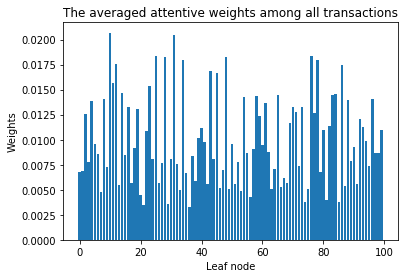

In [5]:
plt.bar(range(100),attention_weight.mean(axis=0))
plt.xlabel("Leaf node")
plt.ylabel("Weights")
plt.title("The averaged attentive weights among all transactions")
plt.show()

## Sample transactions
Due to the great amount of transactions, we sample 1 licit and 1 illicit transaction for demonstration.

In [6]:
number_sampled = 1
illicit_sample = test[test.illicit==1].sample(number_sampled,random_state=1) # sample from illicit samples
transaction_id = illicit_sample.index[0] # get the index of sampled data
print("Index of sampled data:",transaction_id)

Index of sampled data: 2340


In [7]:
illicit_sample

,sgd.id,sgd.date,importer.id,declarant.id,country,office.id,tariff.code,quantity,gross.weight,fob.value,...,RiskH.HS6.Origin,RiskH.tariff.code,RiskH.quantity,RiskH.HS6,RiskH.HS4,RiskH.HS2,RiskH.office.id,RiskH.office.id&importer.id,RiskH.office.id&HS6,RiskH.office.id&country
2340,SGD83019,13-11-08,IMP712264,DEC4546,CNTRY680,OFFICE59,8703331226,435,1602,2008,...,0,0,0,0,0,0,0,0,0,0


### Take a look at the inspection information (Not available in Synthetic data)

In [9]:
print("Checking the inspection information of sampled data")
print("-"*52)
for text in illicit_sample['INSPECTION.INFORMATION'].values:
    print(text.strip())
    print("-"*52)

## Analyze attention weight with XGBoost leaf-nodes

In [11]:
# load leaf_index dictionary to project lead-id into XGBoost tree structure
with open("../leaf_index.pickle","rb") as f:
    leaf_index = pickle.load(f)

In [12]:
# first, take a look at the prediction probability of the transaction
print("Prediction probability:%.4f" % predicted_illicit_prob[transaction_id])
top_k = 5 # number of cross feature to observe (select top k)
test_leaves = test_dataset.tensors[0].numpy() # the leaf index for all transactions
tree_id = np.argsort(attention_weight[transaction_id])[-top_k:] # obtain which trees have the hightest weights
print("Trees with the highest attention weights:",tree_id)
leaf_id = [test_leaves[transaction_id][i] for i in tree_id] # obtain the leaf-id for the trees
print("The corresponding index of the leaf node:",leaf_id)

# transform the leaf index to the original XGBoost tree structure
# Variable leaf_index is a dictionary with {leaf-id: {tree-id,node-id}}
xgb_cross_feature = [leaf_index[l] for l in leaf_id] 
print("The node id in the original XGBoost model:",xgb_cross_feature)

Prediction probability:0.0441
Trees with the highest attention weights: [76 48 25 31 10]
The corresponding index of the leaf node: [1171, 743, 388, 476, 157]
The node id in the original XGBoost model: [{76: 21}, {48: 15}, {25: 23}, {31: 15}, {10: 15}]


In [14]:
# read the contents of the file
with open('../xgb_model.txt', 'r') as f:
    txt_model = f.read()

# Note: To maintain the clearness, only print the result for the first tree. Please print the whole text data when analyzing by yourself
print(txt_model[:1015]) 

booster[0]:
0:[RiskH.office.id&importer.id<0.5] yes=1,no=2,missing=1
	1:[RiskH.HS6.Origin<0.5] yes=3,no=4,missing=3
		3:[RiskH.office.id&HS6<0.5] yes=7,no=8,missing=7
			7:[RiskH.importer.id<0.5] yes=15,no=16,missing=15
				15:leaf=-0.190891355
				16:leaf=-0.133655965
			8:[RiskH.importer.id<0.5] yes=17,no=18,missing=17
				17:leaf=-0.10510204
				18:leaf=0.0617283955
		4:[tariff.code<8.70200115e+09] yes=9,no=10,missing=9
			9:[gross.weight<193616.5] yes=19,no=20,missing=19
				19:leaf=0.16952841
				20:leaf=-0.0300000012
			10:[RiskH.importer.id<0.5] yes=21,no=22,missing=21
				21:leaf=-0.105105102
				22:leaf=0.0823529437
	2:[gross.weight<182429.5] yes=5,no=6,missing=5
		5:[tariff.code<8.70200115e+09] yes=11,no=12,missing=11
			11:[quantity<8227] yes=23,no=24,missing=23
				23:leaf=0.184650645
				24:leaf=-0.0133333346
			12:[RiskH.quantity<0.5] yes=25,no=26,missing=25
				25:leaf=0.0363143645
				26:leaf=0.166878983
		6:[RiskH.quantity<0.5] yes=13,no=14,missing=13
			13:[RiskH.offi

## Extract dicision path
From the previous cell, we could see that the tree structure is revealed. "**booster[id]**" denotes the tree id and follows with it's node id of each leaf-node.<br>
We have already obtain the leaf-node and their tree-id is [{76: 21}, {48: 15}, {25: 23}, {31: 15}, {10: 15}].<br>
Therefore, we would have decision paths for each leaf-node regrarding to the text file.

* Prediction probability:0.0441
* Trees with the highest attention weights: [76 48 25 31 10]
* The corresponding index of the leaf node: [1171, 743, 388, 476, 157]
* The node id in the original XGBoost model: [{76: 21}, {48: 15}, {25: 23}, {31: 15}, {10: 15}]

### Decision Paths
* Leaf_id: 1171, Tree id: 76, Node id: 21 <br>
path: [0→1→4→10→21] <br>
cross feature: RiskH.importer.id<0.5 | gross.weight>=1068.5 | total.taxes>=340.5 | gross.weight<2078.5

* Leaf_id: 743, Tree id: 48, Node id: 15 <br>
path: [0→1→3→7→15] <br>
cross feature: RiskH.office.id&importer.id<0.5 | RiskH.tariff.code<0.5 | RiskH.quantity<0.5 | quantity<2390.5

* Leaf_id: 388, Tree id: 25, Node id: 23 <br>
path: [0→2→5→11→23] <br>
cross feature: tariff.code>=8.50630093e+09 | tariff.code<8.7046103e+09 | RiskH.office.id&country<0.5 | RiskH.declarant.id<0.5 

* Leaf_id: 476, Tree id: 31, Node id: 15 <br>
path: [0→1→3→7→15] <br>
cross feature: RiskH.quantity<0.5 | RiskH.HS6.Origin<0.5 | RiskH.declarant.id<0.5 | RiskH.HS2<0.5

* Leaf_id: 157, Tree id: 10, Node id: 15 <br>
path: [0→1→3→7→15] <br>
cross feature: RiskH.office.id&importer.id<0.5 | RiskH.HS6.Origin<0.5 | RiskH.importer.id<0.5 | RiskH.office.id&HS6<0.5